# TEM Image Processing Pipeline

In this notebook we implement an image processing pipeline to extract information from transmission electron microscopy images of barium titanate nanoparticles in a low density polyethylene _matrix_. Information gained from this process includes the:
- number of particles, $N_p$
- number of agglomerates, $N_a$
- size of particles (longest and shortest chord lengths)
- locations of particles (x,y)
- number of particles per agglomerate, $n$
- factor of agglomeration

where factor of agglomeration is given by:
$$F_a = \frac{N_a \cdot n}{N_p}$$

#### Steps:

Load Input: We don't need to process input image with 3 color channels as TEM images tend to be grayscale. Each pixel is 8 bits ranging from 0 (light) to 255 (dark).

Gaussian Blur: TEM images have noise (looks like a fine grain filter accross image). To smooth out these grains we apply a gaussian blur.
TODO: explain kernel matrix

Binary Threshold: Convert grayscale pixels to only take on values of 0 (light) or 1 (dark). This helps us reduce image size for faster processing but also results in a significant loss of information from the original image.
TODO: explain OTSU's method

## 1. Import necessary libraries and setup

In [1]:
import cv2 as cv                   # OpenCV for image processing
import matplotlib.pyplot as plt    # Matplotlib for visualizing
import numpy as np                 # NumPy for quick maths
from collections import Counter    # dictionary quick maths
from tem_functions import *        # import necessary functions from separate python file
import time                        # timing how long it takes to import libraries

t_pipe_init = time.perf_counter()  # begin timing pipeline

Define constants

In [2]:
# threshold = 55 # for 36a
# threshold = 35 # for 36b
threshold = 45 # for 36e

print(str(nm_per_pixel), "nm per pixel")

0.8849557522123894 nm per pixel


## 2. Load input data and apply grayscale

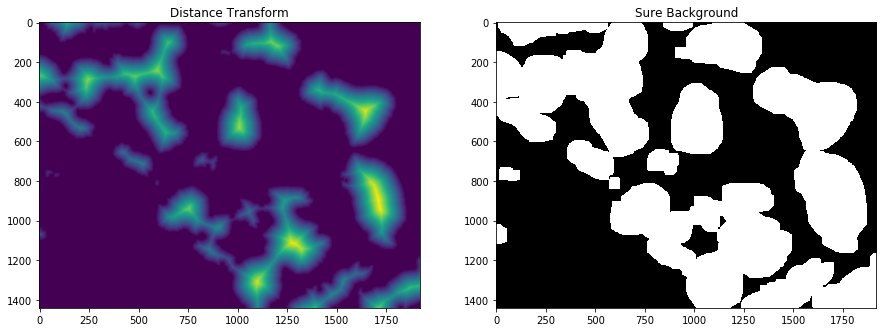

In [3]:
# display images inline in notebook, comment can't be on same line (glitch)
%matplotlib inline 

IMAGE_NAME = "TES-36e-cropped.tif"

color_image, dist_transform, sure_bg = setup(IMAGE_NAME, threshold, False)

## 5. Contours derived from sure background & foreground

### Contour Agglomerates

### Contour particles 

Threshold distance transform with a higher value to get particle centers for watershed algorithm

Text(0.5, 1.0, 'sure foreground')

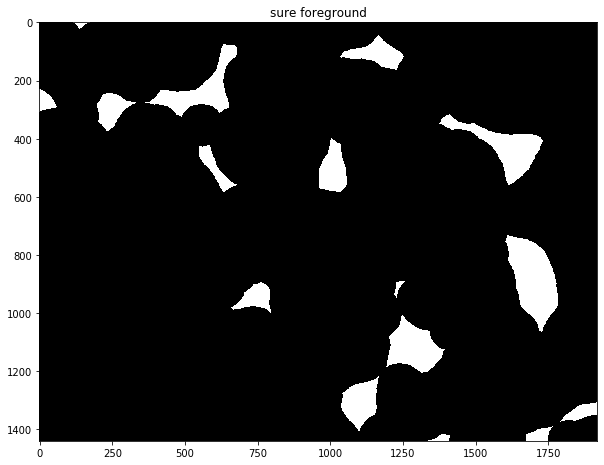

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))



ret_2, sure_fg_2 = cv.threshold(dist_transform, 0.499999999*dist_transform.max(), 255, 0)
axs.imshow(sure_fg_2, cmap = plt.cm.gray)
axs.set_title("sure foreground")

In [5]:
# Finding unknown region
sure_fg_2 = np.uint8(sure_fg_2)
unknown_2 = cv.subtract(sure_bg, sure_fg_2)

## 6. Contours derived from Watershed algorithm

Markers pt.2 except this time they're derived from watershed instead of background - foreground

Text(0.5, 1.0, 'watershed markers')

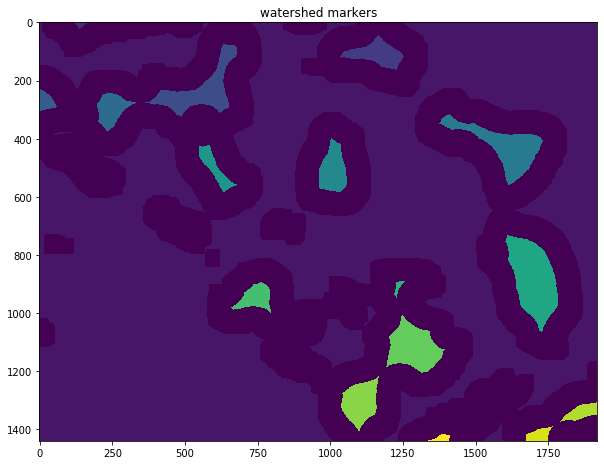

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(10,10))

# Marker labelling
ret_2, watershed_markers = cv.connectedComponents(sure_fg_2)
# Add one to all labels so that sure background is not 0, but 1
watershed_markers += 1
# Now, mark the region of unknown with zero
watershed_markers[unknown_2==255] = 0

axs.imshow(watershed_markers)
axs.set_title("watershed markers")

Run watershed algorithm from particle centers

First obtain contour pixels and get their colors

## Find area of particles
 to see if it is worth it to run watershed on the current threshold

In [7]:
dist_transform_thresh = get_watershed_threshold(dist_transform, sure_bg, color_image, expected_radius)
print(dist_transform_thresh)

0.49999999999999994


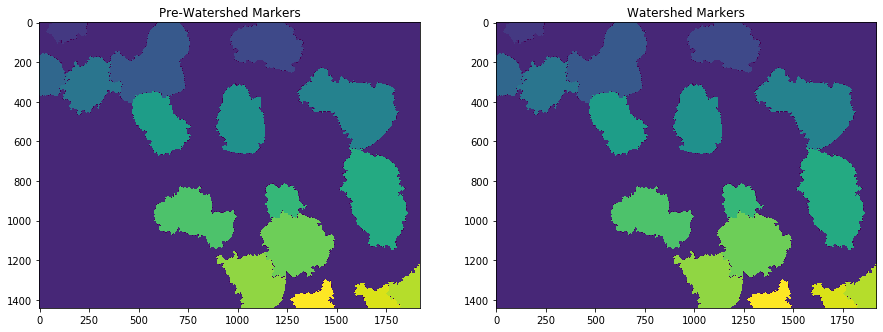

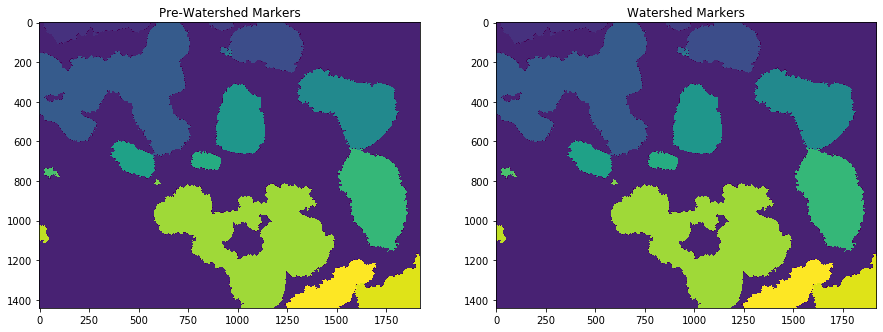

In [8]:
# watershed markers for finding particles (no agglomerates)
watershed_markers = get_watershed_markers(dist_transform, dist_transform_thresh, sure_bg, colorimage, True)
# watershed markers for finding agglomerates
agg_watershed_markers = get_watershed_markers(dist_transform, 0.1, sure_bg, color_image, True)

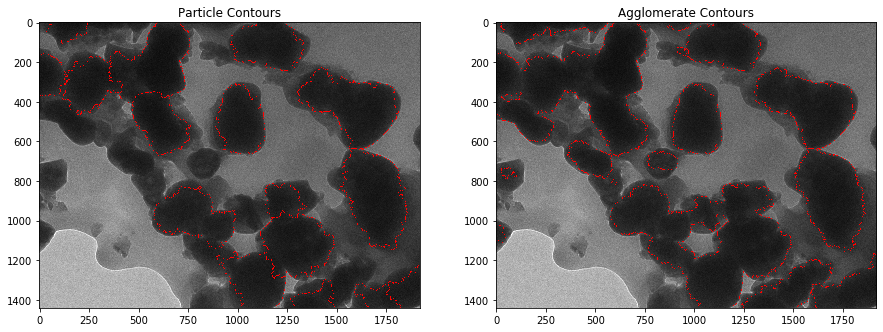

In [9]:
contour_colors, chords_color_copy = get_contour_colors(watershed_markers, color_image)
agg_contour_colors, agg_chords_color_copy = get_contour_colors(agg_watershed_markers, color_image)
display_images([chords_color_copy, agg_chords_color_copy], ["Particle Contours", "Agglomerate Contours"], [1, 1])

In [10]:
particles = find_centerpoints(contour_colors)
agg_particles = find_centerpoints(agg_contour_colors)
print(particles)

{2: [('x', 115.57719879369161), ('y', 43.55366589212439)], 4: [('x', 474.1197588897193), ('y', 191.32261421656622)], 3: [('x', 1002.6346081239122), ('y', 111.01314081018114)], 5: [('x', 59.70779946183811), ('y', 240.06974733590437)], 6: [('x', 213.28322448506398), ('y', 277.467248908297)], 7: [('x', 1357.0438584669753), ('y', 362.59766707096117)], 8: [('x', 883.1022302388066), ('y', 433.3648046897018)], 9: [('x', 530.2187199984792), ('y', 448.37979905516005)], 10: [('x', 1481.9500998365215), ('y', 778.7019442483909)], 11: [('x', 1084.5440494590418), ('y', 800.4705174323974)], 12: [('x', 684.185643720754), ('y', 866.2352770643703)], 13: [('x', 1129.6986632759758), ('y', 995.281936191375)], 14: [('x', 931.0509534018778), ('y', 1127.2377670978424)], 15: [('x', 1631.5329907381504), ('y', 1176.0406696803263)], 17: [('x', 1231.8214334514882), ('y', 1219.2929999276603)], 16: [('x', 1493.9516224188792), ('y', 1215.1465093411998)]}


In [11]:
particle_areas = get_areas(watershed_markers)
agg_areas = get_areas(agg_watershed_markers)

In [17]:
print(particle_areas)
print(agg_areas)

{2: 12357.271516955127, 4: 79866.86506382647, 3: 51654.788941968836, 5: 18226.172762158356, 6: 40827.78604432611, 7: 87098.4415381001, 8: 50967.96930065002, 9: 46039.62722217872, 10: 87740.6218184666, 11: 19289.68595817997, 12: 58149.424387187726, 13: 67034.22351006344, 14: 48690.57874539902, 15: 17451.64069230167, 17: 13806.876027880024, 16: 12996.319210588144}
{2: 23117.706946511084, 5: 219541.85919022636, 3: 2959.511316469575, 4: 54355.078706241686, 6: 704.8320150364164, 7: 343.0182473177226, 8: 317.1744067663874, 9: 92758.24261884252, 10: 53770.06813376146, 11: 20407.236275354375, 13: 93167.04518756364, 12: 8546.479755658236, 14: 1527.1360325789021, 15: 221.63051139478426, 16: 408.80256872112153, 17: 233788.86365416244, 18: 2490.4064531286713, 19: 38125.14684000314, 20: 41416.7123502232}


In [18]:
#sketch of how we should combine

# loop through the agglomerate contours
for particle in agg_particles:
    
    # if the particle has a radius more than twice the expected size
    if agg_areas[particle] > np.pi*(expected_radius)**2:
        pass
        
        # find the max and min x and y for the given agglomerate
        
        # collect a list of the particles dictionary fall within the agglomerate
        
        # replace the agglomerates in the particles dictionary and replace the contours in the contour_colors dictionary 
        


In [12]:
long_pairs, particles = get_long_chord_lengths(particles, contour_colors)
# print(long_pairs)

In [13]:
short_pairs, particles = get_short_chord_lengths(particles, contour_colors, long_pairs)
# print(short_pairs)

In [14]:
print(particles)

{2: [('x', 115.57719879369161), ('y', 43.55366589212439), ('a', 94.78739539097947), ('theta', -12.673860005623133)], 4: [('x', 474.1197588897193), ('y', 191.32261421656622), ('a', 215.46809899325092), ('theta', -51.670952674253876), ('b', 125.21498467761052)], 3: [('x', 1002.6346081239122), ('y', 111.01314081018114), ('a', 166.137332596162), ('theta', -173.4238857894455), ('b', 85.6191831876503)], 5: [('x', 59.70779946183811), ('y', 240.06974733590437), ('a', 102.42765517094033), ('theta', -108.90457584261165), ('b', 56.70626316318866)], 6: [('x', 213.28322448506398), ('y', 277.467248908297), ('a', 140.84425969793108), ('theta', -50.60927444644581), ('b', 94.80701594160583)], 7: [('x', 1357.0438584669753), ('y', 362.59766707096117), ('a', 223.0106054151975), ('theta', -165.52260429120585), ('b', 113.02690065880356)], 8: [('x', 883.1022302388066), ('y', 433.3648046897018), ('a', 161.32490932447112), ('theta', -105.10350645777817), ('b', 104.66636222002914)], 9: [('x', 530.2187199984792)

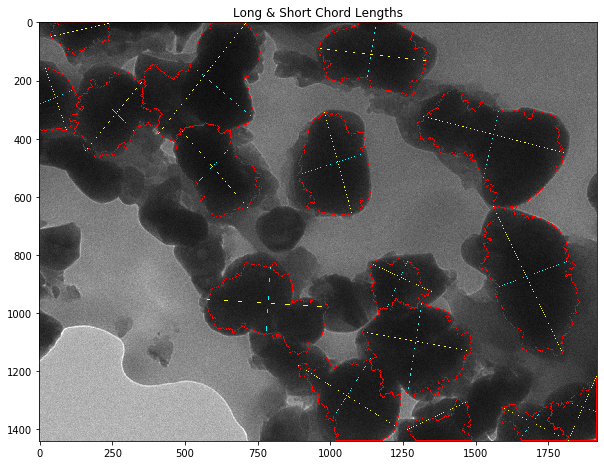

In [15]:
draw_long_lengths(chords_color_copy, long_pairs)
draw_short_lengths(chords_color_copy, short_pairs)
display_images([chords_color_copy], ["Long & Short Chord Lengths"], [0])

In [16]:
t_pipe_final = time.perf_counter()

print("time to run pipeline:", str(t_pipe_final - t_pipe_init), "seconds")

time to run pipeline: 276.145349186 seconds
